# Autoencoder

- 참고링크: https://blog.keras.io/building-autoencoders-in-keras.html
- MNIST data 를 통해 다양한 autoencoder를 학습한다.
- 숙제: autoencoder 로 학습된 feature 로 classification 해 보기

## simple Autoencoder

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Using TensorFlow backend.
/home/slcf/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


- loss function으로 binary crossentropy 를 사용하는 이유는 mnist 의 경우 거의 흰색/검은색 만으로 이루어져있어서 true image 의 경우에 0/1 이 많기 때문에 잘 학습

In [0]:
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [0]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.3540 - val_loss: 0.2703
Epoch 2/50
60000/60000 [==============================] - 4s 67us/step - loss: 0.2619 - val_loss: 0.2500
Epoch 3/50
60000/60000 [==============================] - 4s 67us/step - loss: 0.2396 - val_loss: 0.2274
Epoch 4/50
60000/60000 [==============================] - 4s 67us/step - loss: 0.2201 - val_loss: 0.2106
Epoch 5/50
60000/60000 [==============================] - 4s 67us/step - loss: 0.2060 - val_loss: 0.1987
Epoch 6/50
60000/60000 [==============================] - 4s 67us/step - loss: 0.1957 - val_loss: 0.1898
Epoch 7/50
60000/60000 [==============================] - 4s 67us/step - loss: 0.1874 - val_loss: 0.1823
Epoch 8/50
60000/60000 [==============================] - 4s 68us/step - loss: 0.1806 - val_loss: 0.1760
Epoch 9/50
60000/60000 [==============================] - 4s 6

In [14]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
# 한번에 구함
reconstructed_imgs = autoencoder.predict(x_test)

NameError: name 'encoder' is not defined

**Plot 그리기**

In [15]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

NameError: name 'decoded_imgs' is not defined

## Deep Autoencoder

In [0]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

- Sequential 을 사용하지 않는 이유?
  - 인코딩 된 hidden representation layer에 직접 접근할 수 있도록 하기 위하여
  - 위의 예제에서는 encoded에 해당함

In [0]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

## Convolutional Autoencoder
- image data 를 input 으로 하는 경우 convolution layers 을 사용하여 deep autoencoder 를 학습할 수 있음
- decoder 에 대하여 원래 이미지 사이즈로 복원을 수행해야 함
- convolution을 역으로 수행할 때에 일반 convolution layer를 이용할 수도 있지만 deconv 혹은 Conv2DTranspose (deconvolution)을 사용할 수도 있음
- pooling 의 경우에는 upsampling을 통해서 이미지 사이즈를 늘림
- Unsupervised Learning 이기 때문에 더 충분한 epoch 이 필요함

In [4]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [5]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

- Convolution layer 에 대한 입력은 이미지 모양을 보존하는 형태이어야 함 (필터 차원도 명시)

In [6]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [7]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 106us/step - loss: 0.2309 - val_loss: 0.1808
Epoch 2/50
  128/60000 [..............................] - ETA: 5s - loss: 0.1849

KeyboardInterrupt: 

**HW**
- visualization 코드를 참고하여 학습된 autoencoder 의 encoding 부분의 activation과 filter 를 시각화 해 보기
- conv2d_1 (1, 10, 15)
- conv2d_2 (2, 4, 6)
- conv2d_3 (1, 3, 5)

In [0]:
reconstructed_imgs = autoencoder.predict(x_test)

# Denoising Autoencoder

In [8]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

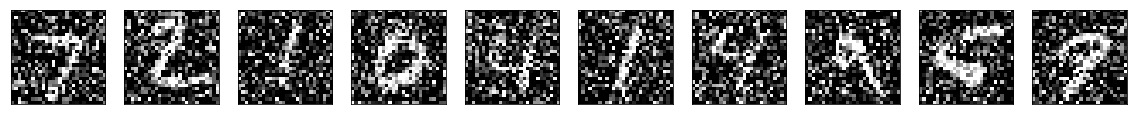

In [18]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [12]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 108us/step - loss: 0.1934 - val_loss: 0.1298
Epoch 2/100
60000/60000 [==============================] - 6s 102us/step - loss: 0.1245 - val_loss: 0.1202
Epoch 3/100
60000/60000 [==============================] - 6s 100us/step - loss: 0.1152 - val_loss: 0.1148
Epoch 4/100
60000/60000 [==============================] - 6s 101us/step - loss: 0.1108 - val_loss: 0.1082
Epoch 5/100
60000/60000 [==============================] - 6s 102us/step - loss: 0.1079 - val_loss: 0.1083
Epoch 6/100
60000/60000 [==============================] - 6s 102us/step - loss: 0.1059 - val_loss: 0.1033
Epoch 7/100
60000/60000 [==============================] - 6s 101us/step - loss: 0.1045 - val_loss: 0.1025
Epoch 8/100
60000/60000 [==============================] - 6s 102us/step - loss: 0.1033 - val_loss: 0.1011
Epoch 9/100
60000/60000 [==============================] - 6s 102us/step - loss: 0.1026 - val_

60000/60000 [==============================] - 6s 102us/step - loss: 0.0945 - val_loss: 0.0940
Epoch 77/100
60000/60000 [==============================] - 6s 104us/step - loss: 0.0945 - val_loss: 0.0940
Epoch 78/100
60000/60000 [==============================] - 6s 104us/step - loss: 0.0944 - val_loss: 0.0944
Epoch 79/100
60000/60000 [==============================] - 6s 103us/step - loss: 0.0944 - val_loss: 0.0941
Epoch 80/100
60000/60000 [==============================] - 6s 104us/step - loss: 0.0944 - val_loss: 0.0952
Epoch 81/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.0944 - val_loss: 0.0939
Epoch 82/100
60000/60000 [==============================] - 6s 103us/step - loss: 0.0944 - val_loss: 0.0939
Epoch 83/100
60000/60000 [==============================] - 6s 104us/step - loss: 0.0943 - val_loss: 0.0942
Epoch 84/100
60000/60000 [==============================] - 6s 103us/step - loss: 0.0943 - val_loss: 0.0946
Epoch 85/100
60000/60000 [===============

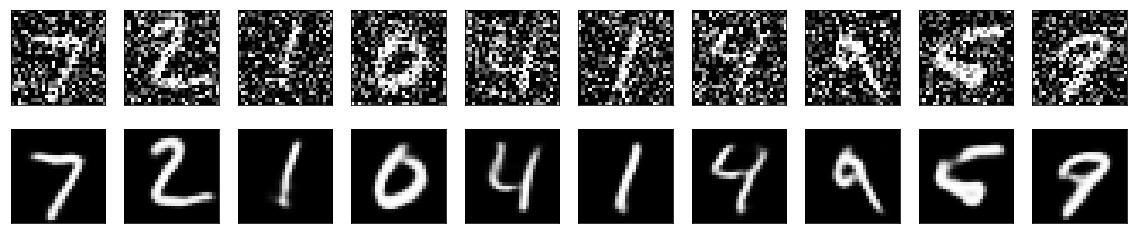

In [19]:
reconstructed_imgs = autoencoder.predict(x_test_noisy)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Variational Autoencoder (VAE)

In [63]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [64]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [84]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test,cmap = plt.cm.RdYlGn)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [66]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [67]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


In [69]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_23[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_23[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

In [70]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [ ]:
## User-defined Loss
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim*objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [77]:
models = (encoder, decoder)
data = (x_test, y_test)

print(vae_loss)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()
plot_model(vae,to_file='vae_mlp.png',show_shapes=True)

<function vae_loss at 0x7f4d441db048>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [82]:
vae.fit(x_train,x_train,epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, x_test))
vae.save_weights('vae_mlp_mnist.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 52us/step - loss: 376.6178 - val_loss: 341.5087
Epoch 2/50
60000/60000 [==============================] - 3s 44us/step - loss: 335.2634 - val_loss: 328.7191
Epoch 3/50
60000/60000 [==============================] - 3s 44us/step - loss: 326.1090 - val_loss: 323.2519
Epoch 4/50
60000/60000 [==============================] - 3s 45us/step - loss: 320.5549 - val_loss: 318.4465
Epoch 5/50
60000/60000 [==============================] - 3s 44us/step - loss: 316.8202 - val_loss: 315.6635
Epoch 6/50
60000/60000 [==============================] - 3s 45us/step - loss: 314.1166 - val_loss: 313.4751
Epoch 7/50
60000/60000 [==============================] - 3s 44us/step - loss: 311.9351 - val_loss: 311.5453
Epoch 8/50
60000/60000 [==============================] - 3s 44us/step - loss: 310.1465 - val_loss: 310.8099
Epoch 9/50
60000/60000 [==============================] - 3s 44us/step - loss:

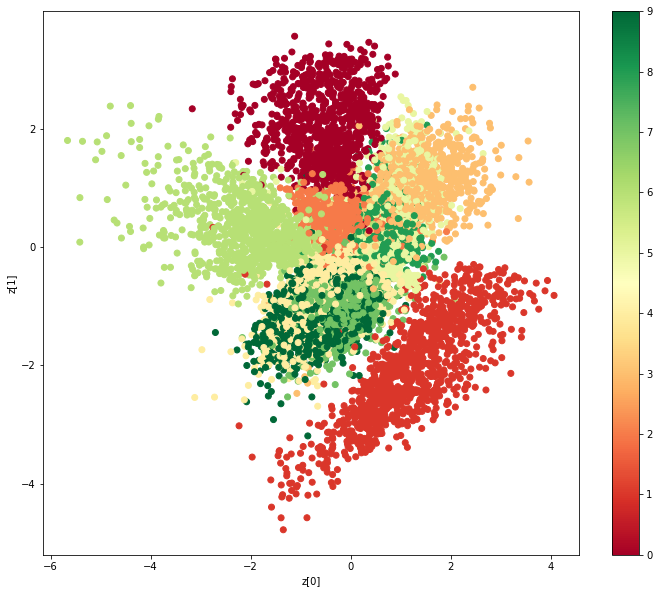

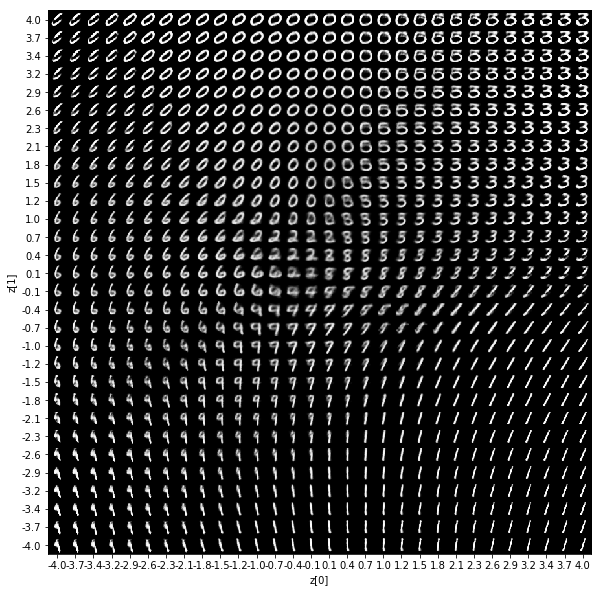

In [85]:
plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")